In [2]:
#always run this cell first, importing python packages
#shift + enter to run a cell
import numpy as np
import matplotlib.pyplot as plt
import os, sys, glob, math, json
import cv2
import torch

In [3]:
from PIL import ImageColor

#type in hex codes to get correpsonding RGB arrays to include in merge_dataset.py (see scriptexample.py for instructions) file
#make sure not to delete commas that seperate entries

hexes = ['#000000',
'#ffa500',
'#228b22',
'#7cfc00',
'#8b4513',
'#d35d0e',
'#5f9ea0',
'#0000ff',
'#2dbdff',
'#ff0004']

for hexi in hexes:
    print(list(ImageColor.getcolor(hexi, "RGB")))

[0, 0, 0]
[255, 165, 0]
[34, 139, 34]
[124, 252, 0]
[139, 69, 19]
[211, 93, 14]
[95, 158, 160]
[0, 0, 255]
[45, 189, 255]
[255, 0, 4]


In [4]:
root = '/Users/kristynlang/Desktop/kristyn/Images'

#set root directory - this is the folder you will be working in (folder that contains all of the folders that contain images/masks)
#ex: root = '/Users/username/master_folder_location'

## Convert Masks

In [18]:
# Import parameters needed for merging

#change from merge_th_regional to the appropriate name of merge_dataset file
# The landcover classes, hex values, and RGB codes for each category for each scheme live in here
from merge_th_fluvial import mask_categories, category_labels, palette_original, palette_lcc_a, categories_lcc_a,\
    mask_categories_merged, category_labels_merged, output_size, input_size, patch_size, stride_size,\
    pad_size, crop_left, crop_right, crop_up, crop_down, hex_palette, hex_palette_merged, palette_merged

# Import functions
from merge_th_fluvial import RGB2HEX,\
get_image, colourize, merge_classes, class_encode, grid_search, plot_legend,\
plot_samples, plot_profile, plot_grid_profiles

#### Test Merging

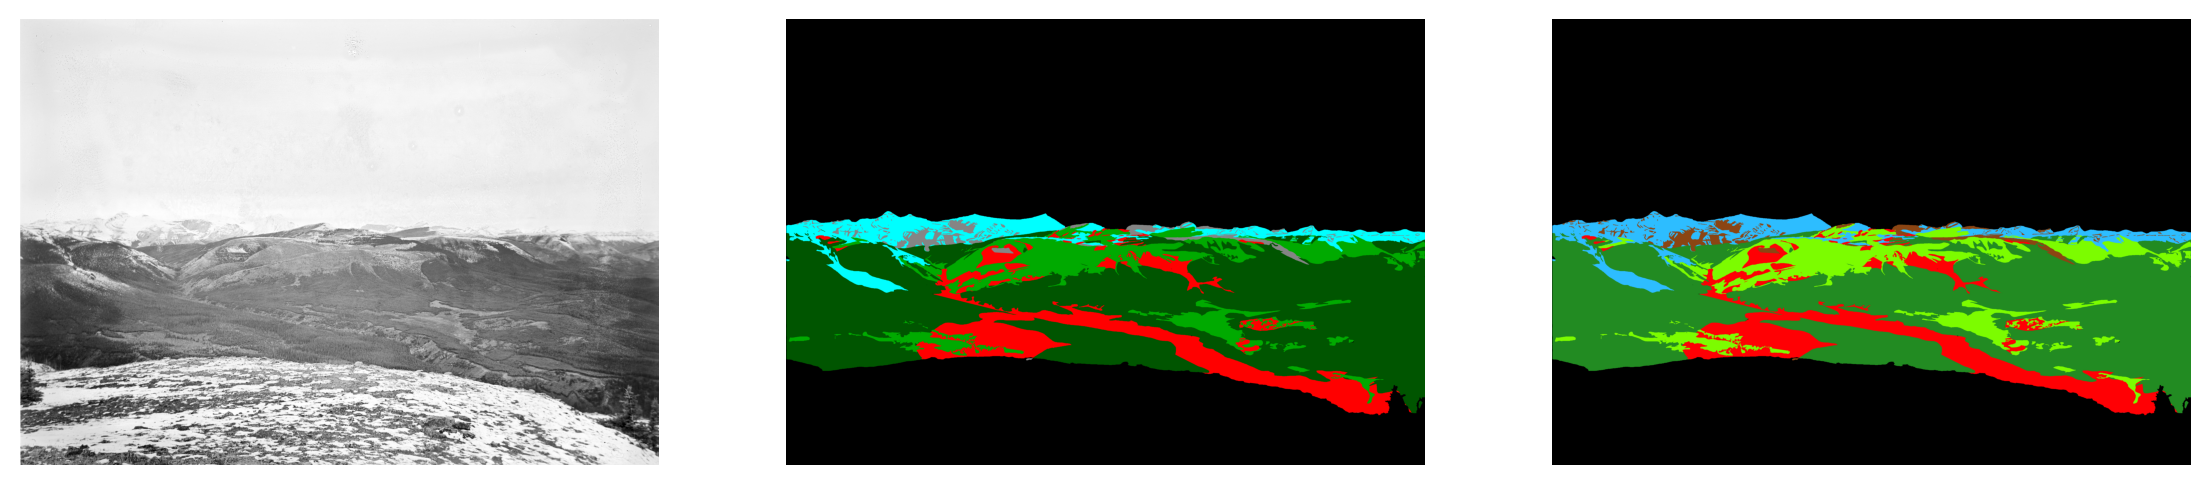

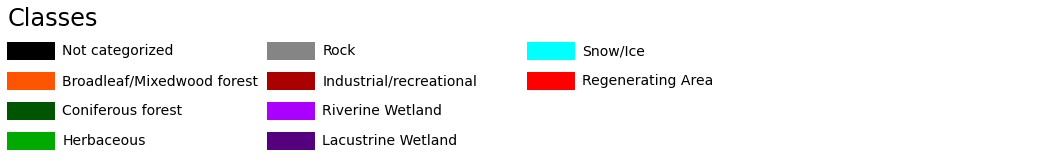

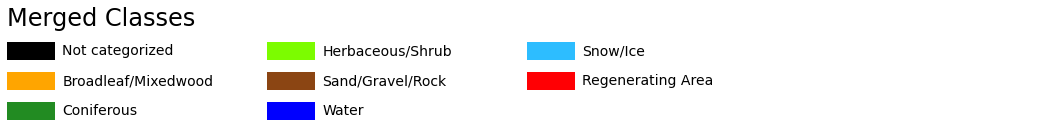

In [6]:
#You can skip this step if you are NOT adding any new classes or merging a different dataset. The merge functions for existing datasets work.
#Test for one image/mask pair to check that merging worked (if a new merge_dataset.py file was created with new categories)

#change img_path and mask_path to match desired image for testing to see that categories are correctly reclassified before saving

img_path = root + '/ImageMaskCollection/TaggartHodgeRegional/Img_TaggartReg_AllSmoke.jpg'

mask_path = root + '/ImageMaskCollection/TaggartHodgeRegional/Mask_TaggartReg_AllSmoke.png'

mask_full = torch.as_tensor(np.expand_dims(np.moveaxis(get_image(mask_path, 3), -1, 0), axis=0), dtype=torch.uint8)
mask_merged = merge_classes(class_encode(mask_full).numpy())
mask_merged = colourize(mask_merged, palette=palette_merged)

fig, axes = plt.subplots(1, 3, sharex='col', sharey='row', dpi=200, figsize=(14,10))
plt.rcParams.update({'font.size': 1})
axes[0].imshow(get_image(img_path))
axes[0].axis('off')
axes[1].imshow(get_image(mask_path))
axes[1].axis('off')
axes[2].imshow(mask_merged[0])
axes[2].axis('off')
plt.show()

plot_legend(hex_palette, 'Classes')
plot_legend(hex_palette_merged, 'Merged Classes', categories=mask_categories_merged)

## Merge and save masks

In [19]:
#Set directory that contains mask/image pairs (subfolder within master folder
#can use mydir = root if you are working in the same folder
mydir = root + 'CorrectPlease/TaggartFluvial/'

In [15]:
#create a merge directory for new masks
directory = 'Merge'
path = os.path.join(mydir + directory)
os.mkdir(path)

In [20]:
#Grab unique filenames for saving and loading masks
def get_mask_image_paths(folder_path):
    mask_paths = []
    img_paths = []
    filenames = os.listdir(folder_path)
    
    for filename in filenames:
        parts = filename.split("_")
        if len(parts) > 2:
            unique_part = "_".join(parts[1:])
            
            if filename.lower().endswith('.png'):
                #update string in front of + unique part to match the start of the filename (part of the filename that is the same between all files)
                mask_path = os.path.join(folder_path, 'Mask_' + unique_part)
                mask_paths.append(mask_path)
            elif filename.lower().endswith('.jpg'):
                img_path = os.path.join(folder_path, 'Img_' + unique_part)
                img_paths.append(img_path)
            elif filename.lower().endswith('.tif'):
                img_path = os.path.join(folder_path, 'Img_' + unique_part)
                img_paths.append(img_path)
    
    return mask_paths, img_paths

#create merged masks for each file
mask_paths, img_paths = get_mask_image_paths(mydir)
merge_dir = os.path.join(mydir + 'Merge')

merged = []

for mask, image in zip(mask_paths, img_paths):
    #print(mask)
    mask_full = torch.as_tensor(np.expand_dims(np.moveaxis(get_image(mask, 3), -1, 0), axis=0), dtype=torch.uint8)
    mask_merged = merge_classes(class_encode(mask_full).numpy())
    mask_merged = colourize(mask_merged, palette=palette_merged)
    #print(mask_merged)
    merged.append(mask_merged)
    mask_merged_tosave = cv2.cvtColor(np.squeeze(mask_merged), cv2.COLOR_RGB2BGR)
    
    #save merged masks to created directory 'Merge' - masks will have the EXACT same filename as the old versions but will be located in a different folder
    mask_filename = os.path.basename(mask)
    merged_mask_filename = os.path.splitext(mask_filename)[0] + '.png'
    save_path = os.path.join(merge_dir, merged_mask_filename)
    cv2.imwrite(save_path, mask_merged_tosave)

In [21]:
 print('number of images =',len(img_paths))

number of images = 8


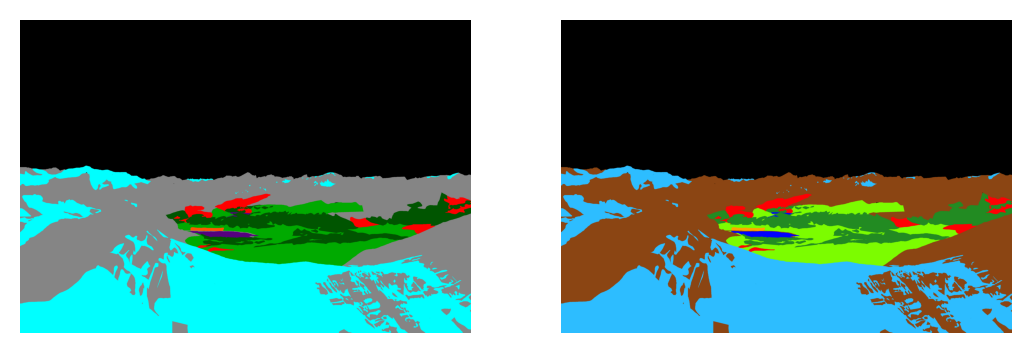

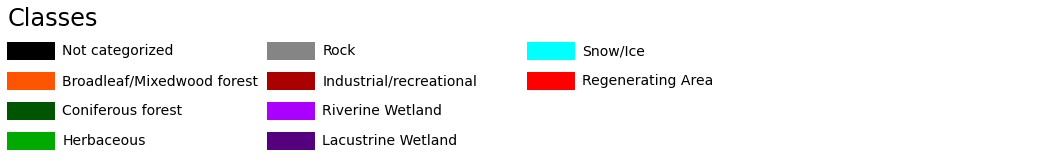

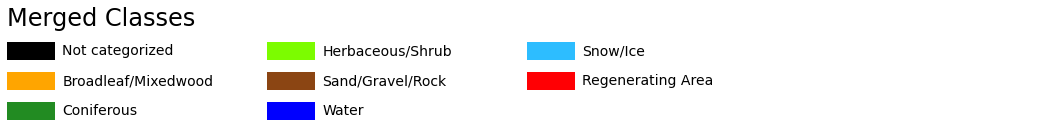

In [12]:
#view converted masks

#select image number from 0 to len(img_paths)
i = 17
fig, axes = plt.subplots(1, 2, sharex='col', sharey='row', dpi=200)# figsize=(14,10))
plt.rcParams.update({'font.size': 1})
# axes[0].imshow(get_image(img_paths[i]))
# axes[0].axis('off')
axes[0].imshow(get_image(mask_paths[i]))
axes[0].axis('off')
axes[1].imshow(merged[i][0])
axes[1].axis('off')
plt.show()

plot_legend(hex_palette, 'Classes')
plot_legend(hex_palette_merged, 'Merged Classes', categories=mask_categories_merged)